In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import json
import string
import pickle
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.lines as mlines


from openquake.hazardlib.gsim.bahrampouri_2021_duration import (
    BahrampouriEtAldm2021Asc,
    BahrampouriEtAldm2021SInter,
    BahrampouriEtAldm2021SSlab,
    )

from openquake.hazardlib.gsim.kotha_2020 import KothaEtAl2020ESHM20
from openquake.hazardlib.gsim.bchydro_2016_epistemic import (
    BCHydroESHM20SInter, BCHydroESHM20SSlab
    )

from pickagm.avgSA import indirect_AvgSA_GMPE

from phd_project.config.config import load_config
from phd_project.plotting import custom_log_formatter
from phd_project.scripts.run_r_code import run_r_script
from phd_project.scripts.WP1_ground_motion_set.correlation import (
    get_correlations_for_residual_dataset,
    ensure_positive_definiteness,
    )
import phd_project.scripts.WP1_ground_motion_set.manage_flatfiles as mf
from phd_project.scripts.WP1_ground_motion_set.residual_partitioning.residuals import (
    calculate_residuals,
    unmangle_AvgSA_column_names
    )

cfg = load_config()

In [4]:
PROCESSED_DATA = cfg["proc_data"]["corr_model"]
RESULTS = cfg["results"]["corr_model"]

total_residuals_tail = "_total_residuals.csv"
partitioned_residuals_tail = "_partitioned_residuals_lmer.csv"
summary_json_tail = "_partitioned_residuals_summary_lmer.json"

tails = [
    total_residuals_tail,
    partitioned_residuals_tail,
    summary_json_tail
]

n_records_min = 3

gmms_for_residual_calcs = {
    "asc": {
        "file": "",
        "gmm_PGA_SA": KothaEtAl2020ESHM20(),
        "gmm_RSD595": BahrampouriEtAldm2021Asc(),
        "gmm_AvgSA": indirect_AvgSA_GMPE(KothaEtAl2020ESHM20(), mean_only=True)
        },
    "sslab": {
        "file": "",
        "gmm_PGA_SA": BCHydroESHM20SSlab(),
        "gmm_RSD595": BahrampouriEtAldm2021SSlab(),
        "gmm_AvgSA": indirect_AvgSA_GMPE(BCHydroESHM20SSlab(), mean_only=True)
        },
    "sinter": {
        "file": "",
        "gmm_PGA_SA": BCHydroESHM20SInter(),
        "gmm_RSD595": BahrampouriEtAldm2021SInter(),
        "gmm_AvgSA": indirect_AvgSA_GMPE(BCHydroESHM20SInter(), mean_only=True)
        },
    "vran": {
        "file": "",
        "gmm_PGA_SA": BCHydroESHM20SSlab(),
        "gmm_RSD595": BahrampouriEtAldm2021SSlab(),
        "gmm_AvgSA": indirect_AvgSA_GMPE(BCHydroESHM20SSlab(), mean_only=True)
        },
}

tectonic_regions = [k for k in gmms_for_residual_calcs.keys()]

fault_types = ["reverse", "normal", "strikeslip"]
fault_rakes = [90, 0, -90]

In [31]:
# non active shallow crust datasets from GFZ
non_asc_data_folder = cfg["raw_data"]["root"] / "eshm20_subduction_vrancea_datasets"
non_asc_data_files = [
    "hellenic_inslab_db.json", 
    "hellenic_interface_db.json", 
    "vrancea_db.json"]
tags = ["sslab", "sinter", "vran"]

# outputfile names
# flatfile_folder = cfg["raw_data"]["gm_flatfiles"]

# flatfile_filenames = {"asc": "asc_flatfile.csv",
#                       "sslab": "sslab_flatfile.csv",
#                       "sinter": "sinter_flatfile.csv",
#                       "vran": "vrancea_esm_flatfile.csv"}

# flatfile_folder_normal_ss = flatfile_folder / "normal_and_strikeslip"
# flatfile_folder_normal_ss.mkdir(parents=True, exist_ok=True)

# residuals_folder_normal_ss = residuals_folder / "normal_and_strikeslip"
# residuals_folder_normal_ss.mkdir(parents=True, exist_ok=True)

In [51]:
def get_residuals_folder(ft: str):
    return PROCESSED_DATA / ft / "residual_partitioning"

# Organise Flatfiles for each of the Tectonic Regimes and Fault Types

The subduction interface, subduction slab and the vancea datasets used in ESHM20 were provided by
Graeme Weatherill from the Deutsche Geoforschungszentrum.
The majority of records are missing rake angle data. For the calculation of the 
significant duration the fault type must be supplied. Flatfiles are generated assuming different rake angles (-90, 0, 90) 
to test how the assumed rake angle affects the correlations.

In [32]:
# Check if the provided datasets are indeed subsets of esm
esm_df = mf.load_esm_flatfile(cfg["raw_data"]["esm_flatfile"]) 
datasets = {}
for f, tag in zip(non_asc_data_files, tags):
    name = f.split(".")[0]
    with open(non_asc_data_folder / f, "r") as file:
        db = json.load(file)

    if mf.dataset_is_subset_of_esm(db, esm_df):
        print(f"{name} is a subset of the ESM-Database")    

    datasets[tag] = db

hellenic_inslab_db is a subset of the ESM-Database
hellenic_interface_db is a subset of the ESM-Database
vrancea_db is a subset of the ESM-Database


In [33]:
# Add and rename columns so that the they match the tags used in OpenQuake
# for the site and rupture context arrays. Start with a rake angle of 
esm_df = mf.add_site_rup_ctx_columns(esm_df, rake_angle=90)

In [34]:
# Add some columns for the extra IMs (AvgSA[0,3] and AvgSA[0,6])
components = ["rotD50", "rotD50"]
AvgSA_tags = ["AvgSA[0,3]", "AvgSA[0,6]"]
AvgSA_periods = [np.round(np.linspace(0, 3, 10), 2),
                 np.round(np.linspace(0, 6, 10), 2)] 
im_start_idx = 84
esm_df = mf.add_AvgSA_columns(esm_df, components, AvgSA_tags, AvgSA_periods, im_start_idx)

In [35]:
# drop records with missing metadata and/or missing imdata
n1 = len(esm_df)
esm_df = mf.drop_records_with_missing_metadata(esm_df)
esm_df = mf.drop_records_with_missing_imdata(esm_df, im_start_idx)
n2 = len(esm_df)

print(f"{n1-n2} records dropped. {n2} records remaining")

283 records dropped. 20984 records remaining


In [36]:
# extract the flatfiles for each regime for the reverse fault type and save
df = esm_df.copy()
flatfiles = {}
for ft, rake in zip(fault_types, fault_rakes):
    ft_flatfiles = {}
    df = mf.set_new_rake(df, new_rake_angle=rake)
    
    for tag, db in datasets.items():
        ft_flatfiles[tag] = mf.extract_flatfile_for_dataset(db, df)

    deep_events = pd.concat([v for v in ft_flatfiles.values()], axis=0)
    ft_flatfiles["asc"] = mf.get_active_shallow_crust_flatfile(deep_events, esm_df)

    flatfiles[ft] = ft_flatfiles

for ft, ft_flatfiles in flatfiles.items():
    for trt_tag, ff in ft_flatfiles.items():
        save_folder = PROCESSED_DATA / ft / "flatfiles"
        save_folder.mkdir(parents=True, exist_ok=True)
        ff.to_csv(save_folder / f"{trt_tag}_{ft}_flatfile.csv", sep=";", index=True)

In [37]:
# Print a short summary and save the flatfiles
for tag, df in flatfiles["reverse"].items():
    print(f"Flatfile: {tag}:")
    mf.print_summary(df)
    print()

Flatfile: sslab:
No. Events:  110
No. Records:  624
No. Stations:  169
Mw (min/max):  1.69 6.2

Flatfile: sinter:
No. Events:  145
No. Records:  546
No. Stations:  142
Mw (min/max):  1.69 6.5

Flatfile: vran:
No. Events:  46
No. Records:  649
No. Stations:  88
Mw (min/max):  3.8 7.5

Flatfile: asc:
No. Events:  1019
No. Records:  18441
No. Stations:  1865
Mw (min/max):  3.05 7.4



# Determine Residuals

In [ ]:
# calculate the total residuals for each model and save as csv files
for ft in fault_types:
    for trt_tag, gmms in gmms_for_residual_calcs.items():
        flatfile_fp = PROCESSED_DATA / ft / "flatfiles" / f"{trt_tag}_{ft}_flatfile.csv"
        residuals_folder = get_residuals_folder(ft)
        residuals_folder.mkdir(parents=True, exist_ok=True)
        residuals_fp = residuals_folder / f"{trt_tag}_{ft}{total_residuals_tail}"
        calculate_residuals(flatfile_fp, gmms, residuals_fp)

Calculating residuals:
    Flatfile  :  asc_reverse_flatfile.csv
    Output file: asc_reverse_total_residuals.csv
    GMM PGA/SA:  [KothaEtAl2020ESHM20]
    GMM RSD595:  [BahrampouriEtAldm2021Asc]
    GMM AvgSA :  [indirect_AvgSA_GMPE with [[KothaEtAl2020ESHM20]]]

Calculating residuals:
    Flatfile  :  sslab_reverse_flatfile.csv
    Output file: sslab_reverse_total_residuals.csv
    GMM PGA/SA:  [BCHydroESHM20SSlab]
    GMM RSD595:  [BahrampouriEtAldm2021SSlab]
    GMM AvgSA :  [indirect_AvgSA_GMPE with [[BCHydroESHM20SSlab]]]

Calculating residuals:
    Flatfile  :  sinter_reverse_flatfile.csv
    Output file: sinter_reverse_total_residuals.csv
    GMM PGA/SA:  [BCHydroESHM20SInter]
    GMM RSD595:  [BahrampouriEtAldm2021SInter]
    GMM AvgSA :  [indirect_AvgSA_GMPE with [[BCHydroESHM20SInter]]]

Calculating residuals:
    Flatfile  :  vran_reverse_flatfile.csv
    Output file: vran_reverse_total_residuals.csv
    GMM PGA/SA:  [BCHydroESHM20SSlab]
    GMM RSD595:  [BahrampouriEtAldm

In [ ]:
# partition the residuals using the lme4 library in R.
# This codes runs the R script through the command line which partitions the
# residuals and saves the results as csv files
r_script_fp = cfg["scripts"]["residual_partitioning"] / "residual_partitioning_lmer.R"

for ft in fault_types:
    print(f"::: Processing residuals for fault type: {ft} :::")
    residuals_folder = get_residuals_folder(ft)
    cmds = [str(residuals_folder), ",".join(gmms_for_residual_calcs.keys())] 
    cmds +=  [f"_{ft}{t}" for t in tails] 
    cmds += [str(n_records_min)]
    run_r_script(r_script_fp, cmds)
    print()

::: Processing residuals for fault type: reverse :::
Executing R script: residual_partitioning_lmer.R...
--- R Standard Output ---
[1] "Running in Pipeline Mode (Arguments detected)"
[1] "Partitioning Residuals for model: asc"
[1] "Partitioning Residuals for model: sslab"
[1] "Partitioning Residuals for model: sinter"
[1] "Partitioning Residuals for model: vran"

R script 'residual_partitioning_lmer.R' completed successfully.
::: Processing residuals for fault type: normal :::
Executing R script: residual_partitioning_lmer.R...
--- R Standard Output ---
[1] "Running in Pipeline Mode (Arguments detected)"
[1] "Partitioning Residuals for model: asc"
[1] "Partitioning Residuals for model: sslab"
[1] "Partitioning Residuals for model: sinter"
[1] "Partitioning Residuals for model: vran"

R script 'residual_partitioning_lmer.R' completed successfully.
::: Processing residuals for fault type: strikeslip :::
Executing R script: residual_partitioning_lmer.R...
--- R Standard Output ---
[1] "Ru

In [52]:
# R mangles some of the column names because it doesn't allow [] and , in the name.
# here we open each folder and repair the broken column names
for ft in fault_types:
    residuals_folder = get_residuals_folder(ft)
    partitioned_residuals_files = [residuals_folder / f for f in os.listdir(residuals_folder) 
                                if (partitioned_residuals_tail in f) and
                                    (f[-4:] == ".csv")]

    for f in partitioned_residuals_files:
        df = pd.read_csv(f, index_col="index")
        column_labels = [unmangle_AvgSA_column_names(c) if "_AvgSA." in c else c for c in df.columns ]
        df.columns = column_labels
        df.to_csv(f, index=True)

    partitioned_residuals_summaries = [residuals_folder / f for f in os.listdir(residuals_folder) 
                                    if (summary_json_tail in f) and
                                        (f[-5:] == ".json")]
    for f in partitioned_residuals_summaries:
        with open(f, "r") as file:
            s = json.load(file)

        new_s = {(unmangle_AvgSA_column_names(k) if "_AvgSA." in k else k) : v for k,v in s.items()}
        
        with open(f, "w") as file:
            json.dump(new_s, file, indent=4)


# View the Summaries of the Statistical Fits

In [55]:
# load the results summary for each tectonic region -> uses the reverse faulting assumption
fit_summaries = {}
ft = "reverse"
for tr in tectonic_regions:
    summary_json = get_residuals_folder(ft) / f"{tr}_{ft}{summary_json_tail}"
    with open(summary_json, "r") as f:
        r_summary = json.load(f)
        df = pd.DataFrame.from_dict(r_summary).T
        df["sigma"] = np.sqrt(df["tau"] ** 2 + df["phi_S2S"] ** 2 + df["phi_ss"] ** 2)
        fit_summaries[tr] = df

In [56]:
# The mean of the residuals of each IM is close to zero...
print("Zero Mean Residuals...")
for tr, s in fit_summaries.items():
    print(f"  Tectonic Regime: {tr}\n"
          f"      dBe   : {all(abs(s["mean_dBe"]) <= 1e-12)}\n"
          f"      dS2Ss : {all(abs(s["mean_dS2Ss"]) <= 1e-12)}\n"
          f"      dWSes : {all(abs(s["mean_dWSes"]) <= 1e-12)}\n")

Zero Mean Residuals...
  Tectonic Regime: asc
      dBe   : True
      dS2Ss : True
      dWSes : True

  Tectonic Regime: sslab
      dBe   : True
      dS2Ss : True
      dWSes : True

  Tectonic Regime: sinter
      dBe   : True
      dS2Ss : True
      dWSes : True

  Tectonic Regime: vran
      dBe   : True
      dS2Ss : True
      dWSes : True



In [57]:
tr_colours = {
    "asc": "k",
    "sslab": "r",
    "sinter": "b",
    "vran": "g",
    }

tr_markers = {
    "asc": "o",
    "sslab": "s",
    "sinter": "d",
    "vran": "*",
    }

var_linestyles = {
    "tau": "-",
    "phi_S2S": "--",
    "phi_ss": "-.",
    "sigma": ":",
    }

legend_font_params = {'size': 9}
legend_title_font_params = {'weight': 'bold', 'size': 9}

Text(0.5, 1.0, 'Model Bias Calculated from LMER')

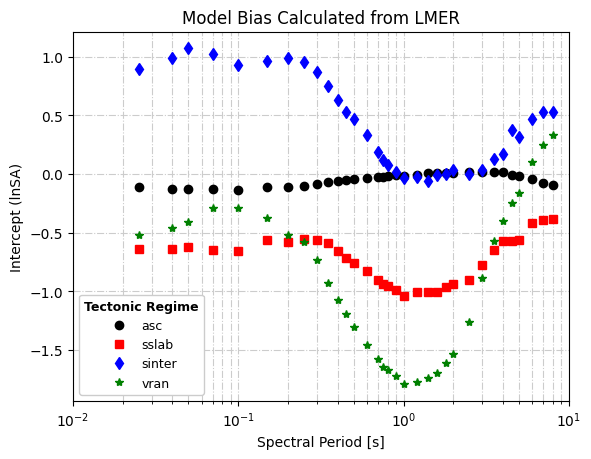

In [87]:
# The intercepts
fig, ax = plt.subplots()

# plot just the spectral accelerations

for tr, s in fit_summaries.items():
    periods = [float(im.split("_")[-1]) for im in s.index if "SA_" in im]
    intercepts = [float(row["intercept"]) for im, row in s.iterrows() if "SA_" in im]
    ax.semilogx(periods, intercepts, 
            color=tr_colours[tr], 
            ls="none", marker=tr_markers[tr],
            label=f"{tr}")

ax.grid(True, which="both", axis="x", ls="-.", color="0.8")
ax.grid(True, which="major", axis="y", ls="-.", color="0.8")
ax.minorticks_on()
ax.tick_params(axis='y', which='minor', left=False)
ax.set_xlim(0.01, 10)
leg = ax.legend(title="Tectonic Regime",
                title_fontproperties=legend_title_font_params,
                prop=legend_font_params,
                frameon=True,
                )
# Set the legend background to solid white
frame = leg.get_frame()
frame.set_facecolor('white')
frame.set_alpha(1.0) # 1.0 is fully opaque

ax.set_xlabel("Spectral Period [s]")
ax.set_ylabel("Intercept (lnSA)")
ax.set_title("Model Bias Calculated from LMER")


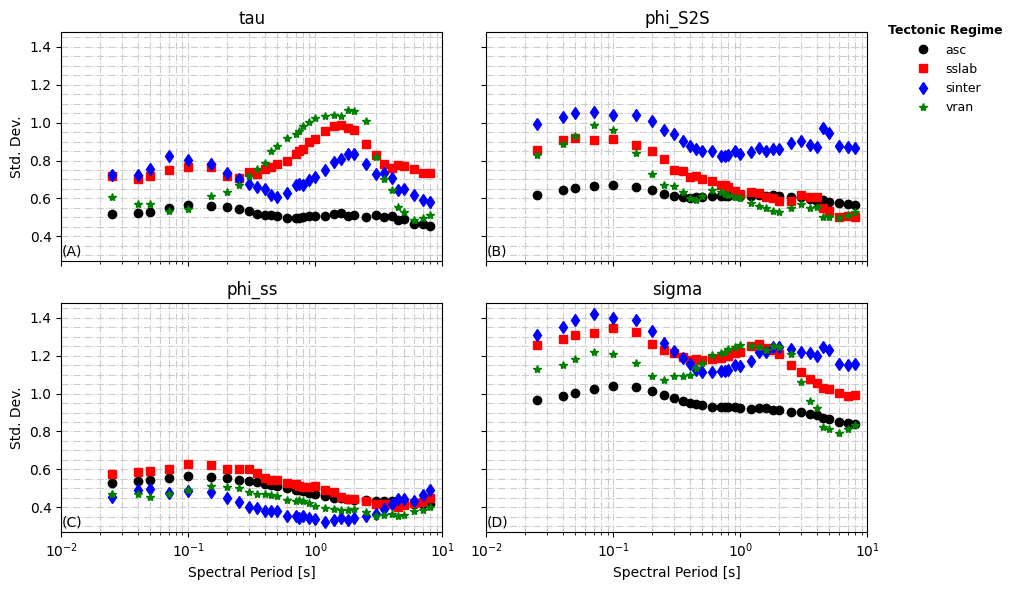

In [100]:
# Plot a summary of the standard deviations
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True,
                        figsize=(9, 6))
axs = axs.flatten()

var_types = ["tau", "phi_S2S", "phi_ss", "sigma"]
for tr, s in fit_summaries.items():
    for ii, var_type in enumerate(var_types):
        periods = [float(im.split("_")[-1]) for im in s.index if "SA_" in im]
        var = [float(row[var_type]) for im, row in s.iterrows() if "SA_" in im]
        axs[ii].semilogx(periods, var, 
                color=tr_colours[tr], 
                ls="none", marker=tr_markers[tr],
                label=f"{tr}")

for ii, ax in enumerate(axs):
    ax.grid(True, which="both", ls="-.", color="0.8")
    ax.minorticks_on()
    ax.tick_params(axis='y', which='minor', left=False)
    ax.set_xlim(0.01, 10)
    ax.text(0.01, 0.3, f"({string.ascii_uppercase[ii]})")
    ax.set_title(f"{var_types[ii]}")

axs[2].set_xlabel("Spectral Period [s]")
axs[3].set_xlabel("Spectral Period [s]")
axs[0].set_ylabel("Std. Dev.")
axs[2].set_ylabel("Std. Dev.")

handles = [
    mlines.Line2D([], [], color=color, label=key, marker=tr_markers[key], ls="none") 
    for key, color in tr_colours.items()
]

# loc="center left" tells matplotlib which part of the legend box to anchor
# bbox_to_anchor=(1, 0.5) moves that anchor point to the far right (1) and middle height (0.5)
fig.legend(handles=handles, 
           loc="upper left", 
           bbox_to_anchor=(0.98, 0.97), 
           title="Tectonic Regime",
           title_fontproperties=legend_title_font_params,
           prop=legend_font_params,
           frameon=False)
plt.tight_layout()

# plt.show()
# im_labels = ["_".join(im.split("_")[1:]) for im in s.index]
# print("IM Labels:")
# for ii in range(len(im_labels)):
#     print(f"  {ii:<3}  {im_labels[ii]}")

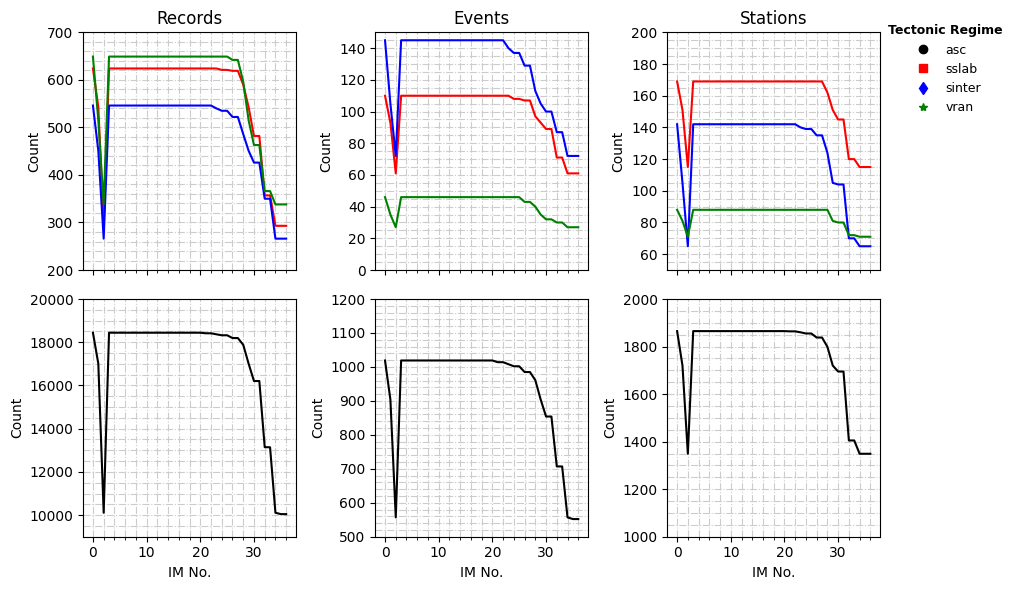

IM Labels:
  0    RSD595_None
  1    AvgSA[0,3]_3.0
  2    AvgSA[0,6]_6.0
  3    PGA_None
  4    SA_0.025
  5    SA_0.04
  6    SA_0.05
  7    SA_0.07
  8    SA_0.1
  9    SA_0.15
  10   SA_0.2
  11   SA_0.25
  12   SA_0.3
  13   SA_0.35
  14   SA_0.4
  15   SA_0.45
  16   SA_0.5
  17   SA_0.6
  18   SA_0.7
  19   SA_0.75
  20   SA_0.8
  21   SA_0.9
  22   SA_1.0
  23   SA_1.2
  24   SA_1.4
  25   SA_1.6
  26   SA_1.8
  27   SA_2.0
  28   SA_2.5
  29   SA_3.0
  30   SA_3.5
  31   SA_4.0
  32   SA_4.5
  33   SA_5.0
  34   SA_6.0
  35   SA_7.0
  36   SA_8.0


In [60]:
# # Plot a summary of the number of events stations and records 
fig, axs = plt.subplots(2, 3, sharex=True,
                        figsize=(9, 6))
(n_rows, n_cols) = axs.shape

n_types = ["n_records", "n_events", "n_stations"]

for jj, n_type in enumerate(n_types):
    for tr, s in fit_summaries.items():
        if tr == "asc": ii = 1 
        else: ii = 0

        xs = np.arange(len(s["intercept"]))
        axs[ii, jj].plot(xs, s[n_type], 
                         color=tr_colours[tr], 
                         ls="-",
                         label=f"{tr}")

axs = axs.flatten()
for ii, ax in enumerate(axs):
    ax.grid(True, which="both", ls="-.", color="0.8")
    ax.minorticks_on()
    ax.tick_params(axis='y', which='minor', left=False)
    ax.set_ylabel("Count")
    
    # formatter = ticker.FuncFormatter(custom_log_formatter)
    # ax.xaxis.set_major_formatter(formatter)
    # ax.text(-1, 0.1, f"({string.ascii_uppercase[ii]})")
    # ax.text(0.022, 1.03, f"T = {periods_to_plot[ii]}s")

axs[0].set_ylim(200, 700)
axs[1].set_ylim(0, 150)
axs[2].set_ylim(50, 200)
axs[3].set_ylim(9000, 20000)
axs[4].set_ylim(500, 1200)
axs[5].set_ylim(1000, 2000)


axs[3].set_xlabel("IM No.")
axs[4].set_xlabel("IM No.")
axs[5].set_xlabel("IM No.")

axs[0].set_title("Records")
axs[1].set_title("Events")
axs[2].set_title("Stations")

handles = [
    mlines.Line2D([], [], color=color, label=key, marker=tr_markers[key], ls="none") 
    for key, color in tr_colours.items()
]

# loc="center left" tells matplotlib which part of the legend box to anchor
# bbox_to_anchor=(1, 0.5) moves that anchor point to the far right (1) and middle height (0.5)
fig.legend(handles=handles, 
           loc="upper left", 
           bbox_to_anchor=(0.98, 0.97), 
           title="Tectonic Regime",
           title_fontproperties=legend_title_font_params,
           prop=legend_font_params,
           frameon=False)
plt.tight_layout()

plt.show()
im_labels = ["_".join(im.split("_")[1:]) for im in s.index]
print("IM Labels:")
for ii in range(len(im_labels)):
    print(f"  {ii:<3}  {im_labels[ii]}")

# Calculate the IM Correlations

In [78]:
# load data, calculate the correlations for each model and save
idx = pd.IndexSlice
rhos = {}

for ft in fault_types:
    print(f":::  Calculating Correlation Coefficients for fault type: {ft} :::")
    save_folder = PROCESSED_DATA / ft / "correlations"
    save_folder.mkdir(parents=True, exist_ok=True)
    ft_rhos = {}

    for tr in tectonic_regions:
        residuals_filepath =  get_residuals_folder(ft)/ f"{tr}_{ft}{partitioned_residuals_tail}"
        tr_rhos = get_correlations_for_residual_dataset(residuals_filepath)
        for tag, df in tr_rhos.items():
            df.to_csv(save_folder / f"{tr}_{ft}_{tag}.csv", index=True)
        
        ft_rhos[tr] = tr_rhos

    rhos[ft] = ft_rhos

:::  Calculating Correlation Coefficients for fault type: reverse :::
:::  Calculating Correlation Coefficients for fault type: normal :::
:::  Calculating Correlation Coefficients for fault type: strikeslip :::


## Compare with Data from the ESHM20 Project

The data was digitized from plots provided by Graeme Weatherill from the Deutsche Geoforschungszentrum, Potsdam

In [79]:
folder = cfg["raw_data"]["rho_models"] / "ESHM20"
periods = [0.05, 0.20, 1.00, 4.00]

eshm20_data = []
for t in periods:
    t_pt = f"{t:.2f}".replace(".", "pt")
    eshm20_data.append(np.loadtxt(folder / f"rho_T_{t_pt}.csv", delimiter=","))

Text(0, 0.5, '$\\rho_{SA_{i}SA_{j}}$ [-]')

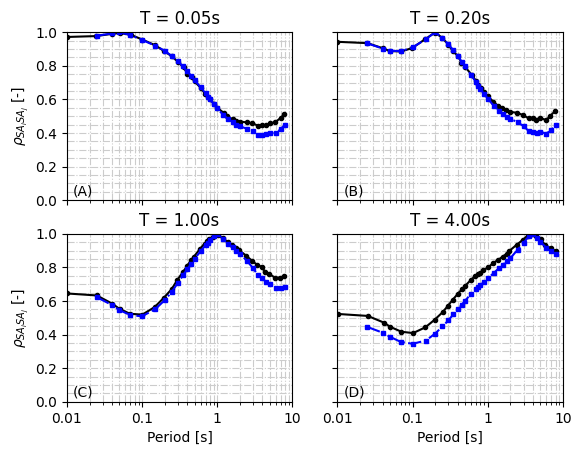

In [80]:
idx = pd.IndexSlice
rho_model = rhos["reverse"]["asc"]["rho_total"]


fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
axs = axs.flatten()

for ii, (t, eshm20) in enumerate(zip(periods, eshm20_data)):
    axs[ii].semilogx(eshm20[:,0], eshm20[:,1], color="k", marker="o", ls="-",
                     ms=3.0, label="ESHM20")
    axs[ii].semilogx(rho_model.loc[idx["rotD50", "SA", t], idx["rotD50", "SA", :]].index.get_level_values(2),
                     rho_model.loc[idx["rotD50", "SA", t], idx["rotD50", "SA", :]],
                     color="b", marker="s", ls="-.",ms=3.0, label="ESHM20")

for ii, (ax, t) in enumerate(zip(axs, periods)):
    ax.grid(True, which="both", ls="-.", color="0.8")
    ax.minorticks_on()
    ax.tick_params(axis='y', which='minor', left=False)
    ax.set_xlim(0.01, 10)
    ax.set_ylim(0, 1.0)
    formatter = ticker.FuncFormatter(custom_log_formatter)
    ax.xaxis.set_major_formatter(formatter)
    ax.text(0.012, 0.03, f"({string.ascii_uppercase[ii]})")
    ax.set_title(f"T = {t:.2f}s")

axs[2].set_xlabel("Period [s]")
axs[3].set_xlabel("Period [s]")
axs[0].set_ylabel("$\\rho_{SA_{i}SA_{j}}$ [-]")
axs[2].set_ylabel("$\\rho_{SA_{i}SA_{j}}$ [-]")

## Check the Rake Assumption 

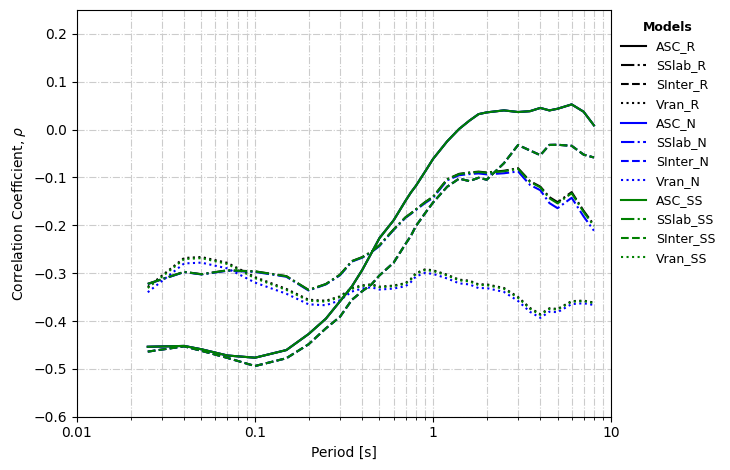

In [81]:
rho_reverse = rhos["reverse"]

rake_models = {
    "ASC_R": rhos["reverse"]["asc"]["rho_total"].loc[idx["rotD50", "SA", :], idx["GM", "RSD595", :]],
    "SSlab_R": rhos["reverse"]["sslab"]["rho_total"].loc[idx["rotD50", "SA", :], idx["GM", "RSD595", :]],
    "SInter_R": rhos["reverse"]["sinter"]["rho_total"].loc[idx["rotD50", "SA", :], idx["GM", "RSD595", :]],
    "Vran_R": rhos["reverse"]["vran"]["rho_total"].loc[idx["rotD50", "SA", :], idx["GM", "RSD595", :]],
    "ASC_N": rhos["normal"]["asc"]["rho_total"].loc[idx["rotD50", "SA", :], idx["GM", "RSD595", :]],
    "SSlab_N": rhos["normal"]["sslab"]["rho_total"].loc[idx["rotD50", "SA", :], idx["GM", "RSD595", :]],
    "SInter_N": rhos["normal"]["sinter"]["rho_total"].loc[idx["rotD50", "SA", :], idx["GM", "RSD595", :]],
    "Vran_N": rhos["normal"]["vran"]["rho_total"].loc[idx["rotD50", "SA", :], idx["GM", "RSD595", :]],
    "ASC_SS": rhos["strikeslip"]["asc"]["rho_total"].loc[idx["rotD50", "SA", :], idx["GM", "RSD595", :]],
    "SSlab_SS": rhos["strikeslip"]["sslab"]["rho_total"].loc[idx["rotD50", "SA", :], idx["GM", "RSD595", :]],
    "SInter_SS": rhos["strikeslip"]["sinter"]["rho_total"].loc[idx["rotD50", "SA", :], idx["GM", "RSD595", :]],
    "Vran_SS": rhos["strikeslip"]["vran"]["rho_total"].loc[idx["rotD50", "SA", :], idx["GM", "RSD595", :]],
    }

model_linestyles = {
    "ASC_R": "-",
    "SSlab_R": "-.",
    "SInter_R": "--",
    "Vran_R": ":",
    "ASC_N": "-",
    "SSlab_N": "-.",
    "SInter_N": "--",
    "Vran_N": ":",
    "ASC_SS": "-",
    "SSlab_SS": "-.",
    "SInter_SS": "--",
    "Vran_SS": ":",
    }

model_colours = {
    "ASC_R": "k",
    "SSlab_R": "k",
    "SInter_R": "k",
    "Vran_R": "k",
    "ASC_N": "b",
    "SSlab_N": "b",
    "SInter_N": "b",
    "Vran_N": "b",
    "ASC_SS": "g",
    "SSlab_SS": "g",
    "SInter_SS": "g",
    "Vran_SS": "g",
    }

fig, ax = plt.subplots()

for model_tag, model in rake_models.items():
    rhos2plot = model.values
    Ts = model.index.get_level_values(2)
    ax.semilogx(Ts, rhos2plot, 
                color=model_colours[model_tag], 
                ls=model_linestyles[model_tag],
                label=f"{model_tag}")

ax.grid(True, which="both", axis="x", ls="-.", color="0.8")
ax.grid(True, which="major", axis="y", ls="-.", color="0.8")
ax.minorticks_on()
ax.tick_params(axis='y', which='minor', left=False)
ax.set_xlim(0.01, 10)
ax.set_ylim(-0.6, 0.25)
formatter = ticker.FuncFormatter(custom_log_formatter)
ax.xaxis.set_major_formatter(formatter)

ax.set_xlabel("Period [s]")
ax.set_ylabel("Correlation Coefficient, $\\rho$")

handles = [
    mlines.Line2D([], [], color=color, label=key, linestyle=model_linestyles[key]) 
    for key, color in model_colours.items()
]

# loc="center left" tells matplotlib which part of the legend box to anchor
# bbox_to_anchor=(1, 0.5) moves that anchor point to the far right (1) and middle height (0.5)
fig.legend(handles=handles, 
           loc="upper left", 
           bbox_to_anchor=(0.96, 0.97), 
           title="Models",
           title_fontproperties=legend_title_font_params,
           prop=legend_font_params,
           frameon=False)
plt.tight_layout()

## Make Postive Definite

In [71]:
# make them all positive definite
rhos_PD = {}
pd_check_data = {}
for ft, ft_rhos in rhos.items():
    ft_rhos_PD = {}
    for tr, rho_dfs in ft_rhos.items():
        check_data = {}
        model_rhos_PD = {}

        for tag, rho_df in rho_dfs.items():
            posdef_out = ensure_positive_definiteness(
                rho_df, threshold=1e-8, n=200, print_out=False)
            
            if posdef_out[1]:
                model_rhos_PD[f"{tag}"] = posdef_out[0]
                print(f"PD Matrix found for {tr}_{ft}_{tag}")
            else:
                model_rhos_PD[f"{tag}"] = None
                print(f"Did not find Positive Definite Matrix for {tr}_{tag}")

            check_data[tag] = posdef_out[1:]
        
        ft_rhos_PD[tr] = model_rhos_PD
    rhos_PD[ft] = ft_rhos_PD

# the printed iterations can be ignored so long as the resulting matrices
# are positive definite.

PD Matrix found for asc_reverse_rho_total
PD Matrix found for asc_reverse_rho_dBe
PD Matrix found for asc_reverse_rho_dS2Ss
PD Matrix found for asc_reverse_rho_dWSes
PD Matrix found for asc_reverse_rho_total_B
PD Matrix found for sslab_reverse_rho_total
PD Matrix found for sslab_reverse_rho_dBe
PD Matrix found for sslab_reverse_rho_dS2Ss
PD Matrix found for sslab_reverse_rho_dWSes
PD Matrix found for sslab_reverse_rho_total_B
PD Matrix found for sinter_reverse_rho_total
PD Matrix found for sinter_reverse_rho_dBe
PD Matrix found for sinter_reverse_rho_dS2Ss
PD Matrix found for sinter_reverse_rho_dWSes
PD Matrix found for sinter_reverse_rho_total_B
PD Matrix found for vran_reverse_rho_total
PD Matrix found for vran_reverse_rho_dBe
PD Matrix found for vran_reverse_rho_dS2Ss
PD Matrix found for vran_reverse_rho_dWSes
PD Matrix found for vran_reverse_rho_total_B
PD Matrix found for asc_normal_rho_total
PD Matrix found for asc_normal_rho_dBe
PD Matrix found for asc_normal_rho_dS2Ss
PD Matrix

In [74]:
# save the correlation coefficients as csvs and pickled dataframes.
# Raw Rhos
for ft, ft_rhos in rhos_PD.items():
    for tr, rho_dfs in ft_rhos.items():
        for tag, rho_df in rho_dfs.items():
            save_folder = RESULTS / ft
            save_folder.mkdir(parents=True, exist_ok=True)
            rho_df.to_csv(save_folder / f"{tr}_{tag}_PD.csv", index=True)

# pickle the dictionary of dataframes for quick loading
with open (RESULTS / "rhos.pkl", "wb") as file:
    pickle.dump(rhos, file)

with open(RESULTS / "rhos_PD.pkl", "wb") as file:
    pickle.dump(rhos_PD, file)

In [75]:
# Load the Positive Definite Model
with open (RESULTS / "rhos_PD.pkl", "rb") as file:
    cg26 = pickle.load(file)

# Models from the Literature 

In [25]:
from openquake.hazardlib.gsim.mgmpe.generic_gmpe_avgsa import (
    BakerJayaramCorrelationModel, 
    ESHM20CorrelationModel,
    AkkarCorrelationModel,
    )

from phd_project.scripts.WP1_ground_motion_set.correlationmodels.B11RSDcorrelations import (
    rho_RSD595_SA,
    rho_RSD595_PGA
    )

from asocorrelationmodel.correlation_models import aso2024_correlation 
from phd_project.scripts.WP1_ground_motion_set.correlationmodels.JC19correlations import jc19_empirical_correlation_model
from phd_project.scripts.WP1_ground_motion_set.correlationmodels.CAN20correlations import can20_empirical_correlation_model
from phd_project.scripts.WP1_ground_motion_set.correlationmodels.AGA16correlations import aga16_empirical_correlation_model
from phd_project.scripts.WP1_ground_motion_set.correlationmodels.ML21correlations import ml21_correlation_model
from phd_project.scripts.WP1_ground_motion_set.correlationmodels.BB17correlations import bb17_empirical_correlation_model

In [26]:
# get the baker and jayaram 2008 and the ESHM20 correlations
ims = cg26["asc"]["rho_total_PD"].columns
im_periods = [float(c[2]) for c in ims if c[1] == "SA"]
labels = [c for c in ims if c[1] == "SA"]
akkar_periods = [t for t in im_periods if t <= 4]
akkar_labels = [c for c in ims 
                if c[1] == "SA" and float(c[2] <= 4)]

bj08 = pd.DataFrame(
    BakerJayaramCorrelationModel(im_periods).rho, 
    index=pd.MultiIndex.from_tuples(labels), 
    columns=pd.MultiIndex.from_tuples(labels))
eshm20 = pd.DataFrame(
    ESHM20CorrelationModel(im_periods).rho, 
    index=pd.MultiIndex.from_tuples(labels), 
    columns=pd.MultiIndex.from_tuples(labels))
akk14 = pd.DataFrame(
    AkkarCorrelationModel(akkar_periods).rho, 
    index=pd.MultiIndex.from_tuples(akkar_labels), 
    columns=pd.MultiIndex.from_tuples(akkar_labels))

In [27]:
# load / create the ASO24 correlation model
aso24 = np.eye(len(im_periods)+3, len(im_periods)+3)

avg_SA_T1 = 1
avg_SA_T2 = 2

# SA-SA Correlations
for ii, Ti in enumerate(im_periods):
    for jj, Tj in enumerate(im_periods[ii+1:]):
        aso24[ii, ii+jj+1] = aso2024_correlation("SA-SA", Ti, Tj)
        aso24[ii+jj+1, ii] = aso2024_correlation("SA-SA", Ti, Tj)

# SA-RSD595 Correlations
for ii, Ti in enumerate(im_periods):
    aso24[ii, aso24.shape[1]-3] = aso2024_correlation("SA-Ds595", Ti)
    aso24[aso24.shape[1]-3, ii] = aso2024_correlation("SA-Ds595", Ti)

# SA-SA_avg3 Correlations
for ii, Ti in enumerate(im_periods):
    for jj, Tj in enumerate([avg_SA_T1, avg_SA_T2]):
        aso24[ii, aso24.shape[1]-2+jj] = aso2024_correlation("SA-Sa_avg3", Ti, Tj)
        aso24[aso24.shape[1]-2+jj, ii] = aso2024_correlation("SA-Sa_avg3", Ti, Tj)

# Sa_avg3-Ds595 Correlations
for jj, Tj in enumerate([avg_SA_T1, avg_SA_T2]):
    aso24[aso24.shape[1]-3, aso24.shape[1]-2+jj] = aso2024_correlation("Sa_avg3-Ds595", Tj)
    aso24[aso24.shape[1]-2+jj, aso24.shape[1]-3] = aso2024_correlation("Sa_avg3-Ds595", Tj)

# Sa_avg3-Sa_avg3 Correlations
    aso24[aso24.shape[1]-2, aso24.shape[1]-1] = aso2024_correlation("Sa_avg3-Sa_avg3", avg_SA_T1, avg_SA_T2)
    aso24[aso24.shape[1]-1, aso24.shape[1]-2] = aso2024_correlation("Sa_avg3-Sa_avg3", avg_SA_T1, avg_SA_T2)

aso24_labels = [("rotD50", "SA", t) for t in im_periods] + \
               [("rotD50", "RSD595", "None")] + \
               [("rotD50", "AvgSA_3", 1.0)] + \
               [("rotD50", "AvgSA_3", 2.0)]

aso24 = pd.DataFrame(aso24,
                     index=pd.MultiIndex.from_tuples(aso24_labels), 
                     columns=pd.MultiIndex.from_tuples(aso24_labels))

In [28]:
# Create the B11 Correlation model for between significant duration and PGA/SA
b11 = [rho_RSD595_PGA()] + [rho_RSD595_SA(t) for t in im_periods] + [1]
b11_labels = [("GMRotI50", "PGA", "None")] + \
             [("GMRotI50", "SA", t) for t in im_periods] + \
             [("GM", "RSD595", "None")]
b11 = pd.DataFrame(b11, 
                   index=pd.MultiIndex.from_tuples(b11_labels),
                   columns=pd.MultiIndex.from_tuples([("GM", "RSD595", "None")]))


In [63]:
# load other models BB17, JC19, CAN20, AGA16
bb17 = bb17_empirical_correlation_model()
aga16 = aga16_empirical_correlation_model()
can20 = can20_empirical_correlation_model(which="total")
jc19 = jc19_empirical_correlation_model(which="total")
ml21_sinter = ml21_correlation_model(which="sinter_total", periods=im_periods)
ml21_sslab = ml21_correlation_model(which="sslab_total", periods=im_periods)

In [59]:
all_models = {
    "AGA16": aga16,
    "AKK14": akk14,
    "ASO24": aso24,
    "BJ08": bj08,
    "B11": b11,
    "BB17": bb17,
    "CAN20": can20,
    "ESHM20": eshm20,
    "JC19": jc19,
    "ML21_SInter": ml21_sinter,
    "ML21_SSlab": ml21_sslab,    
    "CG26_ASC": cg26["asc"]["rho_total"],
    "CG26_SSlab": cg26["sslab"]["rho_total"],
    "CG26_SInter": cg26["sinter"]["rho_total"],
    "CG26_Vran": cg26["vran"]["rho_total"]
    }

# Plot Correlation Models

In [60]:
# Organise the Correlation Models
idx = pd.IndexSlice

model_colours = {
    "BJ08": "b",
    "B11": "r",
    "ESHM20": "g", 
    "BB17": 'b',
    "AKK14": "darkorange",
    "ASO24": "m",
    "AGA16": "y",
    "JC19": "c",
    "CAN20": "tab:brown",
    "ML21_SSlab": "tab:pink",
    "ML21_SInter": "tab:pink",
    "CG26_SSlab": "k",
    "CG26_SInter": "k",
    "CG26_Vran": "k",
    "CG26_ASC": "k",
    }

model_linestyles = {
    "BJ08": "-",
    "B11": "-",
    "ESHM20": "-", 
    "BB17": '--',
    "AKK14": "-",
    "ASO24": "-",
    "CG26_ASC": "-",
    "AGA16": "-",
    "JC19": "-",
    "CAN20": "-",
    "ML21_SSlab": "-",
    "ML21_SInter": "--",
    "CG26_SSlab": ":",
    "CG26_SInter": "--",
    "CG26_Vran": "-.",
    }

max_periods = {
    "BJ08": 10,
    "B11": 10,
    "ESHM20": 8, 
    "BB17": 10,
    "AKK14": 4,
    "ASO24": 10,
    "CG26_ASC": 8,
    "CG26_SSlab": 8,
    "CG26_SInter": 8,
    "CG26_Vran": 8,
    "AGA16": 5,
    "JC19": 6,
    "CAN20": 10,
    "ML21_SSlab": 10,
    "ML21_SInter": 10,
    }

legend_font_params = {'size': 9}
legend_title_font_params = {'weight': 'bold', 'size': 9}

## SA-SA -> Active Shallow Crust

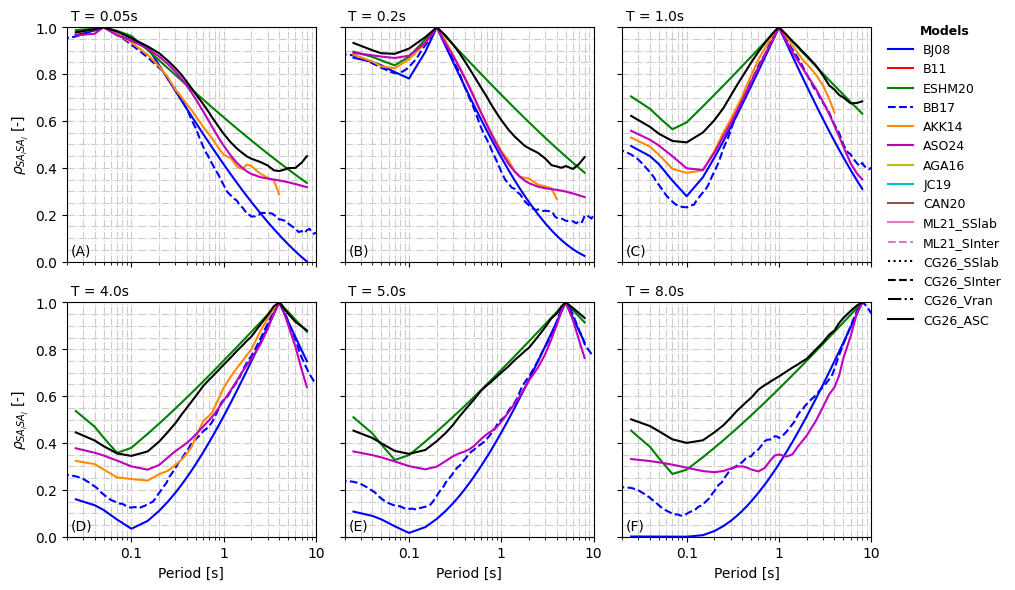

In [47]:
SA_models = {
    "BJ08": bj08,
    "ESHM20": eshm20,
    "BB17": bb17.loc[idx["rotD50", "SA", :], idx["rotD50", "SA", :]],
    "AKK14": akk14,
    "ASO24": aso24.loc[idx["rotD50", "SA", :], idx["rotD50", "SA", :]],
    "CG26_ASC": cg26["asc"]["rho_total"].loc[idx["rotD50", "SA", :], idx["rotD50", "SA", :]],
    }

# plot the correlation models
periods_to_plot = [0.1, 0.5, 1.0, 3.0, 5.0, 8.0]
periods_to_plot = [0.05, 0.2, 1.0, 4.0, 5.0, 8.0]

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True,
                        figsize=(9, 6))
axs = axs.flatten()

for model_tag, model in SA_models.items():
    for ii, period in enumerate(periods_to_plot):
        if period > max_periods[model_tag]:
            continue # skip periods outside bounds of the correlation model
        try:
            rhos = model.loc[idx["rotD50", "SA", period], :]
            Ts = model.index.get_level_values(2)
            axs[ii].semilogx(Ts, rhos,
                            color=model_colours[model_tag], 
                            ls=model_linestyles[model_tag])
        except KeyError:
            continue

for ii, ax in enumerate(axs):
    ax.grid(True, which="both", ls="-.", color="0.8")
    ax.minorticks_on()
    ax.tick_params(axis='y', which='minor', left=False)
    ax.set_xlim(0.02, 10)
    ax.set_ylim(0, 1.0)
    formatter = ticker.FuncFormatter(custom_log_formatter)
    ax.xaxis.set_major_formatter(formatter)
    ax.text(0.022, 0.03, f"({string.ascii_uppercase[ii]})")
    ax.text(0.022, 1.03, f"T = {periods_to_plot[ii]}s")

axs[3].set_xlabel("Period [s]")
axs[4].set_xlabel("Period [s]")
axs[5].set_xlabel("Period [s]")
axs[0].set_ylabel("$\\rho_{SA_{i}SA_{j}}$ [-]")
axs[3].set_ylabel("$\\rho_{SA_{i}SA_{j}}$ [-]")

handles = [
    mlines.Line2D([], [], color=color, label=key, linestyle=model_linestyles[key]) 
    for key, color in model_colours.items()
]

# loc="center left" tells matplotlib which part of the legend box to anchor
# bbox_to_anchor=(1, 0.5) moves that anchor point to the far right (1) and middle height (0.5)
fig.legend(handles=handles, 
           loc="upper left", 
           bbox_to_anchor=(0.98, 0.97), 
           title="Models",
           title_fontproperties=legend_title_font_params,
           prop=legend_font_params,
           frameon=False)
plt.tight_layout()

## SA-SA -> Subduction / Deep Seismicity

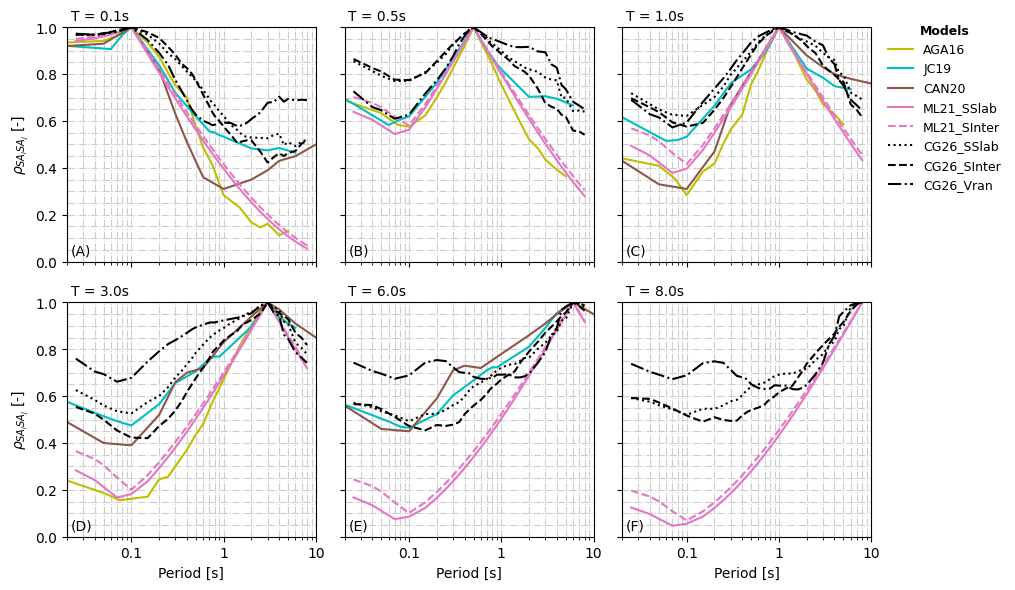

In [64]:
SA_models = {
    "AGA16": aga16.loc[idx[:, "SA", :], idx[:, "SA", :]],
    "JC19": jc19.loc[idx[:, "SA", :], idx[:, "SA", :]],
    "CAN20": can20.loc[idx[:, "SA", :], idx[:, "SA", :]],
    "ML21_SSlab": ml21_sslab.loc[idx[:, "SA", :], idx[:, "SA", :]],
    "ML21_SInter": ml21_sinter.loc[idx[:, "SA", :], idx[:, "SA", :]],
    "CG26_SSlab": cg26["sslab"]["rho_total"].loc[idx["rotD50", "SA", :], idx["rotD50", "SA", :]],
    "CG26_SInter": cg26["sinter"]["rho_total"].loc[idx["rotD50", "SA", :], idx["rotD50", "SA", :]],
    "CG26_Vran": cg26["vran"]["rho_total"].loc[idx["rotD50", "SA", :], idx["rotD50", "SA", :]],
    }

# plot the correlation models
periods_to_plot = [0.1, 0.5, 1.0, 3.0, 6.0, 8.0]

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True,
                        figsize=(9, 6))
axs = axs.flatten()

for model_tag, model in SA_models.items():
    for ii, period in enumerate(periods_to_plot):
        if period > max_periods[model_tag]:
            continue # skip periods outside bounds of the correlation model
        try:
            rhos2plot = model.loc[idx[:, "SA", period], :].to_numpy().flatten()
            Ts = model.index.get_level_values(2)
            axs[ii].semilogx(Ts, rhos2plot,
                            color=model_colours[model_tag], 
                            ls=model_linestyles[model_tag])
        except KeyError:
            continue
        

for ii, ax in enumerate(axs):
    ax.grid(True, which="both", ls="-.", color="0.8")
    ax.minorticks_on()
    ax.tick_params(axis='y', which='minor', left=False)
    ax.set_xlim(0.02, 10)
    ax.set_ylim(0, 1.0)
    formatter = ticker.FuncFormatter(custom_log_formatter)
    ax.xaxis.set_major_formatter(formatter)
    ax.text(0.022, 0.03, f"({string.ascii_uppercase[ii]})")
    ax.text(0.022, 1.03, f"T = {periods_to_plot[ii]}s")

axs[3].set_xlabel("Period [s]")
axs[4].set_xlabel("Period [s]")
axs[5].set_xlabel("Period [s]")
axs[0].set_ylabel("$\\rho_{SA_{i}SA_{j}}$ [-]")
axs[3].set_ylabel("$\\rho_{SA_{i}SA_{j}}$ [-]")

handles = [
    mlines.Line2D([], [], color=model_colours[key], label=key, linestyle=model_linestyles[key]) 
    for key in SA_models.keys()
]

# loc="center left" tells matplotlib which part of the legend box to anchor
# bbox_to_anchor=(1, 0.5) moves that anchor point to the far right (1) and middle height (0.5)
fig.legend(handles=handles, 
           loc="upper left", 
           bbox_to_anchor=(0.98, 0.97), 
           title="Models",
           title_fontproperties=legend_title_font_params,
           prop=legend_font_params,
           frameon=False)
plt.tight_layout()

## PGA-SA

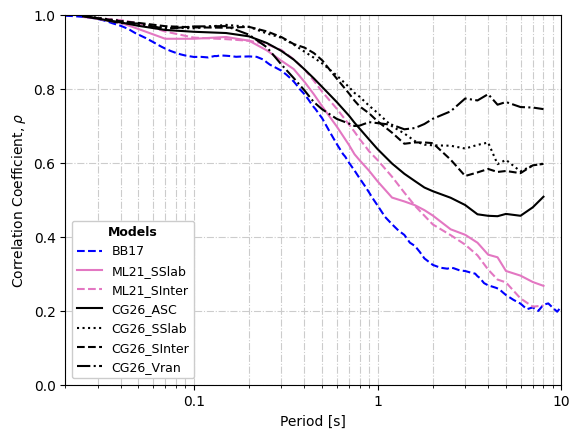

In [65]:
SA_PGA_models = {
    "BB17": bb17.loc[idx["rotD50", "SA", :], idx["rotD50", "PGA", :]],
    "ML21_SSlab": ml21_sslab.loc[idx["rotD50", "SA", :], idx["rotD50", "PGA", :]],
    "ML21_SInter": ml21_sinter.loc[idx["rotD50", "SA", :], idx["rotD50", "PGA", :]],
    "CG26_ASC": cg26["asc"]["rho_total"].loc[idx["rotD50", "SA", :], idx["rotD50", "PGA", :]],
    "CG26_SSlab": cg26["sslab"]["rho_total"].loc[idx["rotD50", "SA", :], idx["rotD50", "PGA", :]],
    "CG26_SInter": cg26["sinter"]["rho_total"].loc[idx["rotD50", "SA", :], idx["rotD50", "PGA", :]],
    "CG26_Vran": cg26["vran"]["rho_total"].loc[idx["rotD50", "SA", :], idx["rotD50", "PGA", :]]
    }

# plot the correlation models
fig, ax = plt.subplots()

for model_tag, model in SA_PGA_models.items():
    rhos = model.values
    Ts = model.index.get_level_values(2)
    ax.semilogx(Ts, rhos,
                color=model_colours[model_tag], 
                ls=model_linestyles[model_tag],
                label=f"{model_tag}")

ax.grid(True, which="both", axis="x", ls="-.", color="0.8")
ax.grid(True, which="major", axis="y", ls="-.", color="0.8")
ax.minorticks_on()
ax.tick_params(axis='y', which='minor', left=False)
ax.set_xlim(0.02, 10)
ax.set_ylim(0, 1.0)
formatter = ticker.FuncFormatter(custom_log_formatter)
ax.xaxis.set_major_formatter(formatter)

ax.set_xlabel("Period [s]")
ax.set_ylabel("Correlation Coefficient, $\\rho$")

leg = ax.legend(title="Models",
                title_fontproperties=legend_title_font_params,
                prop=legend_font_params,
                frameon=True,
                )
# Set the legend background to solid white
frame = leg.get_frame()
frame.set_facecolor('white')
frame.set_alpha(1.0) # 1.0 is fully opaque

## RSD595-SA

Text(0, 0.5, 'Correlation Coefficient, $\\rho$')

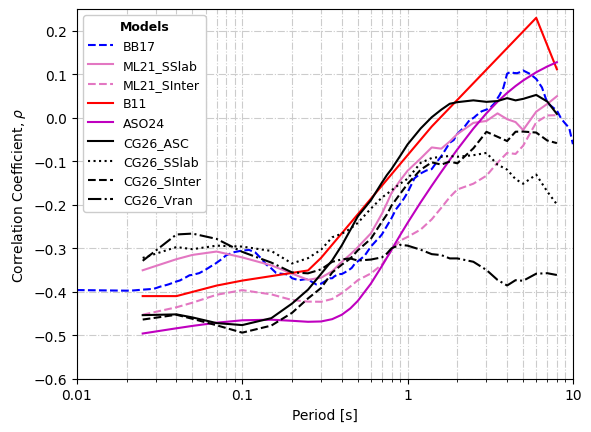

In [66]:
RSD595_models = {
    "BB17": bb17.loc[idx["rotD50", "SA", :], idx["rotD50", "RSD595", :]],
    "ML21_SSlab": ml21_sslab.loc[idx["rotD50", "SA", :], idx["rotD50", "RSD595", :]],
    "ML21_SInter": ml21_sinter.loc[idx["rotD50", "SA", :], idx["rotD50", "RSD595", :]],
    "B11": b11.loc[idx["GMRotI50", "SA", :], idx["GM", "RSD595", :]],
    "ASO24": aso24.loc[idx["rotD50", "SA", :], idx["rotD50", "RSD595", :]],
    "CG26_ASC": cg26["asc"]["rho_total"].loc[idx["rotD50", "SA", :], idx["GM", "RSD595", :]],
    "CG26_SSlab": cg26["sslab"]["rho_total"].loc[idx["rotD50", "SA", :], idx["GM", "RSD595", :]],
    "CG26_SInter": cg26["sinter"]["rho_total"].loc[idx["rotD50", "SA", :], idx["GM", "RSD595", :]],
    "CG26_Vran": cg26["vran"]["rho_total"].loc[idx["rotD50", "SA", :], idx["GM", "RSD595", :]]
    }

fig, ax = plt.subplots()

for model_tag, model in RSD595_models.items():
    rhos = model.values
    Ts = model.index.get_level_values(2)
    ax.semilogx(Ts, rhos, 
                color=model_colours[model_tag], 
                ls=model_linestyles[model_tag],
                label=f"{model_tag}")

ax.grid(True, which="both", axis="x", ls="-.", color="0.8")
ax.grid(True, which="major", axis="y", ls="-.", color="0.8")
ax.minorticks_on()
ax.tick_params(axis='y', which='minor', left=False)
ax.set_xlim(0.01, 10)
ax.set_ylim(-0.6, 0.25)
formatter = ticker.FuncFormatter(custom_log_formatter)
ax.xaxis.set_major_formatter(formatter)
leg = ax.legend(title="Models",
                title_fontproperties=legend_title_font_params,
                prop=legend_font_params,
                frameon=True,
                )
# Set the legend background to solid white
frame = leg.get_frame()
frame.set_facecolor('white')
frame.set_alpha(1.0) # 1.0 is fully opaque

ax.set_xlabel("Period [s]")
ax.set_ylabel("Correlation Coefficient, $\\rho$")


## AvgSA[0,3]-SA

ASO24
CG26_ASC
CG26_SSlab
CG26_SInter
CG26_Vran


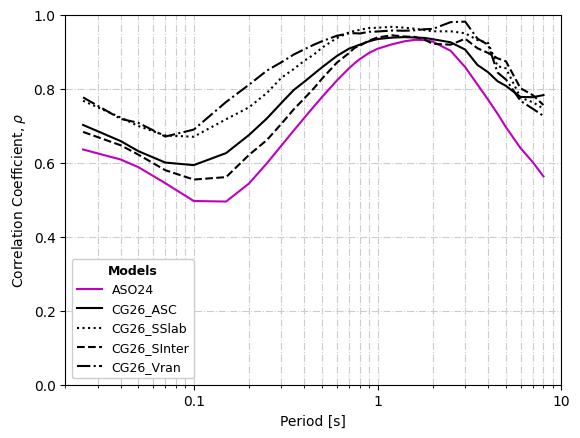

In [67]:
AvgSA03_models = {
    "ASO24": aso24.loc[idx["rotD50", "SA", :], idx["rotD50", "AvgSA_3", 1.0]],
    "CG26_ASC": cg26["asc"]["rho_total"].loc[idx["rotD50", "SA", :], idx["rotD50", "AvgSA[0,3]", :]],
    "CG26_SSlab": cg26["sslab"]["rho_total"].loc[idx["rotD50", "SA", :], idx["rotD50", "AvgSA[0,3]", :]],
    "CG26_SInter": cg26["sinter"]["rho_total"].loc[idx["rotD50", "SA", :], idx["rotD50", "AvgSA[0,3]", :]],
    "CG26_Vran": cg26["vran"]["rho_total"].loc[idx["rotD50", "SA", :], idx["rotD50", "AvgSA[0,3]", :]]
    }

# plot the correlation models
fig, ax = plt.subplots()

for model_tag, model in AvgSA03_models.items():
    print(model_tag)
    rhos = model.values
    Ts = model.index.get_level_values(2)
    ax.semilogx(Ts, rhos,
                color=model_colours[model_tag], 
                ls=model_linestyles[model_tag],
                label=f"{model_tag}")

ax.grid(True, which="both", axis="x", ls="-.", color="0.8")
ax.grid(True, which="major", axis="y", ls="-.", color="0.8")
ax.minorticks_on()
ax.tick_params(axis='y', which='minor', left=False)
ax.set_xlim(0.02, 10)
ax.set_ylim(0, 1.0)
formatter = ticker.FuncFormatter(custom_log_formatter)
ax.xaxis.set_major_formatter(formatter)

ax.set_xlabel("Period [s]")
ax.set_ylabel("Correlation Coefficient, $\\rho$")

leg = ax.legend(title="Models",
                title_fontproperties=legend_title_font_params,
                prop=legend_font_params,
                frameon=True,
                )
# Set the legend background to solid white
frame = leg.get_frame()
frame.set_facecolor('white')
frame.set_alpha(1.0) # 1.0 is fully opaque

## AvgSA[0,6]-SA

ASO24
CG26_ASC
CG26_SSlab
CG26_SInter
CG26_Vran


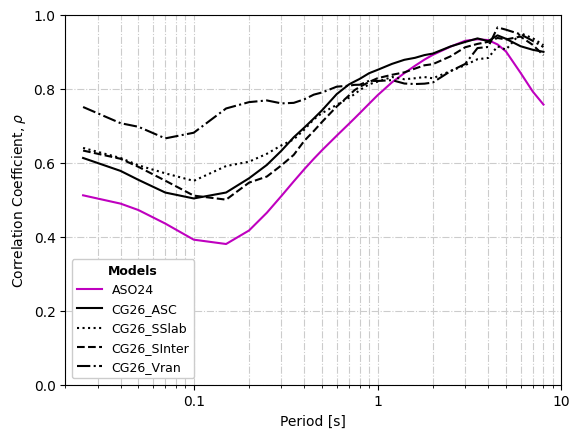

In [68]:
AvgSA06_models = {
    "ASO24": aso24.loc[idx["rotD50", "SA", :], idx["rotD50", "AvgSA_3", 2.0]],
    "CG26_ASC": cg26["asc"]["rho_total"].loc[idx["rotD50", "SA", :], idx["rotD50", "AvgSA[0,6]", :]],
    "CG26_SSlab": cg26["sslab"]["rho_total"].loc[idx["rotD50", "SA", :], idx["rotD50", "AvgSA[0,6]", :]],
    "CG26_SInter": cg26["sinter"]["rho_total"].loc[idx["rotD50", "SA", :], idx["rotD50", "AvgSA[0,6]", :]],
    "CG26_Vran": cg26["vran"]["rho_total"].loc[idx["rotD50", "SA", :], idx["rotD50", "AvgSA[0,6]", :]]
    }

# plot the correlation models
fig, ax = plt.subplots()

for model_tag, model in AvgSA06_models.items():
    print(model_tag)
    rhos = model.values
    Ts = model.index.get_level_values(2)
    ax.semilogx(Ts, rhos,
                color=model_colours[model_tag], 
                ls=model_linestyles[model_tag],
                label=f"{model_tag}")

ax.grid(True, which="both", axis="x", ls="-.", color="0.8")
ax.grid(True, which="major", axis="y", ls="-.", color="0.8")
ax.minorticks_on()
ax.tick_params(axis='y', which='minor', left=False)
ax.set_xlim(0.02, 10)
ax.set_ylim(0, 1.0)
formatter = ticker.FuncFormatter(custom_log_formatter)
ax.xaxis.set_major_formatter(formatter)

ax.set_xlabel("Period [s]")
ax.set_ylabel("Correlation Coefficient, $\\rho$")

leg = ax.legend(title="Models",
                title_fontproperties=legend_title_font_params,
                prop=legend_font_params,
                frameon=True,
                )
# Set the legend background to solid white
frame = leg.get_frame()
frame.set_facecolor('white')
frame.set_alpha(1.0) # 1.0 is fully opaque

## Other IM Combinations

In [69]:
tags = [
    "PGA-AvgSA[0,3]", 
    "PGA-AvgSA[0,6]",
    "PGA-RSD595",
    "AvgSA[0,3]-AvgSA[0,6]", 
    "AvgSA[0,3]-RSD595",
    "AvgSA[0,6]-RSD595"
    ]

# corr_data = np.full((len(tags), len(all_models.keys())), np.nan)

corr_data = {}
for ii, tag in enumerate(tags):
    tag_dict = {}
    im1, im2 = tag.split("-")
    for jj, (model_tag, model) in enumerate(all_models.items()):
        try:
            rho = model.loc[idx[:, im1, :], idx[:, im2, :]].values[0,0]
            tag_dict[model_tag] = rho
        except KeyError:
            ...
    corr_data[tag] = tag_dict

# # manually add the ASO24 values for AvgSA_3
corr_data["AvgSA[0,3]-AvgSA[0,6]"]["ASO24"] = aso24.loc[idx[:, "AvgSA_3", 1], idx[:, "AvgSA_3", 2]].values[0, 0]
corr_data["AvgSA[0,3]-RSD595"]["ASO24"] = aso24.loc[idx[:, "AvgSA_3", 1], idx[:, "RSD595", :]].values[0, 0]
corr_data["AvgSA[0,6]-RSD595"]["ASO24"] = aso24.loc[idx[:, "AvgSA_3", 2], idx[:, "RSD595", :]].values[0, 0]
corr_data = pd.DataFrame.from_dict(corr_data, orient="index")
corr_data

,CG26_ASC,CG26_SSlab,CG26_SInter,CG26_Vran,B11,BB17,ML21_SInter,ML21_SSlab,ASO24
"PGA-AvgSA[0,3]",0.717060,0.783098,0.698931,0.792335,NaN,NaN,NaN,NaN,NaN
"PGA-AvgSA[0,6]",0.623664,0.648565,0.648197,0.762103,NaN,NaN,NaN,NaN,NaN
PGA-RSD595,-0.455539,-0.332792,-0.470925,-0.342980,-0.442,-0.396801,0.0,0.0,NaN
"AvgSA[0,3]-AvgSA[0,6]",0.936763,0.861479,0.919925,0.873424,NaN,NaN,NaN,NaN,0.921097
"AvgSA[0,3]-RSD595",-0.112060,-0.153151,-0.113467,-0.344851,NaN,NaN,NaN,NaN,-0.213030
"AvgSA[0,6]-RSD595",-0.053748,-0.122620,-0.094626,-0.373862,NaN,NaN,NaN,NaN,-0.061026
